### Creation Object-centric log out of triplges generated by trackintel

In [1]:
import sys
import os
import pm4py
import json
# Assuming you're in notebooks/, go one level up
sys.path.append(os.path.abspath(".."))

from pm4mobility.io.loader import *
from pm4mobility.analysis import flows, transport
from pm4mobility.log import ocel_log
import trackintel as ti
#from mobility4py.log.event_log import create_event_log

#### 2. Read trips 

In [2]:
tpls = pd.read_pickle("../data/origin_destination_triplegs_trips_20250909.pkl")

In [3]:
tpls[['trip_id', 'origin', 'destination', 'started_at', 'finished_at', 'geom']]

,trip_id,origin,destination,started_at,finished_at,geom
id,,,,,,
0,0,POINT (-8.97164 39.19398),POINT (-8.94578 39.22333),2024-02-10 12:29:24+00:00,2024-02-10 12:48:27+00:00,"LINESTRING (-8.97164 39.19398, -8.94578 39.22333)"
1,1,POINT (-8.98567 39.20464),POINT (-8.96208 39.23365),2024-03-11 20:57:45+00:00,2024-03-11 20:57:45+00:00,"LINESTRING (-8.98567 39.20464, -8.96208 39.233..."
2,2,POINT (-9.16244 38.71795),POINT (-9.15964 38.71736),2024-02-02 09:12:27+00:00,2024-02-02 09:51:09+00:00,"LINESTRING (-9.16244 38.71795, -9.15964 38.717..."
3,3,POINT (-9.15964 38.71736),POINT (-9.16244 38.71795),2024-02-03 11:24:18+00:00,2024-02-03 11:26:59+00:00,"LINESTRING (-9.15964 38.71736, -9.16244 38.717..."
4,4,POINT (-9.15964 38.71736),POINT (-9.16244 38.71795),2024-02-03 12:05:23+00:00,2024-02-03 12:08:59+00:00,"LINESTRING (-9.15964 38.71736, -9.15964 38.717..."
...,...,...,...,...,...,...
5180056,5180056,POINT (-9.17112 38.82697),POINT (-9.16203 38.84763),2024-03-11 14:55:00+00:00,2024-03-11 15:19:17+00:00,"LINESTRING (-9.17112 38.82697, -9.17112 38.826..."
5180057,5180057,POINT (-9.17067 38.82751),POINT (-9.16577 38.83514),2024-03-11 17:12:42+00:00,2024-03-11 18:08:41+00:00,"LINESTRING (-9.17067 38.82751, -9.17067 38.827..."
5180058,5180058,POINT (-9.17112 38.82697),POINT (-9.17112 38.82697),2024-03-12 15:29:33+00:00,2024-03-12 15:37:32+00:00,"LINESTRING (-9.17112 38.82697, -9.1698 38.8414..."


#### 3. Read districts file 

In [4]:
districts = load_districts_layer("../data/AML_WithOeiras4_FeaturesToJSO.geojson")

In [5]:
districts.head(10)

,OBJECTID,Join_Count,TARGET_FID,Dicofre,Freguesia,Concelho,Distrito,TAA,AREA_EA_Ha,AREA_T_Ha,Des_Simpli,MEAN_X,MEAN_Y,DTMNFR21,Pop,gid,Shape_Length,Shape_Area,geometry
0,1,1.0,62.0,110658,Belém,LISBOA,LISBOA,ÁREA PRINCIPAL,1042.76,1042.76,Belém,-93800.127463,-106327.701172,110658,110658.0,NaN,16052.936004,1.042747e+07,"POLYGON ((-9.19338 38.70058, -9.19367 38.70043..."
1,2,NaN,NaN,111011,Caxias,OEIRAS,LISBOA,ÁREA PRINCIPAL,341.10,NaN,Caxias,NaN,NaN,None,NaN,1.0,11067.557172,6.134831e+06,"POLYGON ((-9.28184 38.69842, -9.28183 38.69842..."
2,3,NaN,NaN,111007,Cruz Quebrada-Dafundo,OEIRAS,LISBOA,ÁREA PRINCIPAL,291.59,NaN,Cruz Quebrada-Dafundo,NaN,NaN,None,NaN,3.0,12328.280155,5.651391e+06,"POLYGON ((-9.2602 38.70161, -9.26002 38.70017,..."
3,4,NaN,NaN,111006,Algés,OEIRAS,LISBOA,ÁREA PRINCIPAL,197.90,NaN,Algés,NaN,NaN,None,NaN,2.0,11464.452396,2.750486e+06,"POLYGON ((-9.2379 38.68265, -9.23675 38.68441,..."
4,5,1.0,55.0,110507,Carcavelos e Parede,CASCAIS,LISBOA,ÁREA PRINCIPAL,810.99,810.99,Carcavelos e Parede,-105299.645661,-107482.650141,110507,110507.0,NaN,20922.434710,1.296668e+07,"POLYGON ((-9.32652 38.66563, -9.32665 38.66781..."
5,6,1.0,83.0,110508,Cascais e Estoril,CASCAIS,LISBOA,ÁREA PRINCIPAL,2915.92,2916.01,Cascais e Estoril,-111799.580516,-105776.096126,110508,110508.0,NaN,40037.517010,4.851248e+07,"POLYGON ((-9.41822 38.6758, -9.39525 38.67742,..."
6,7,1.0,101.0,110506,São Domingos de Rana,CASCAIS,LISBOA,ÁREA PRINCIPAL,2036.43,2036.43,São Domingos de Rana,-105151.112719,-105071.926377,110506,110506.0,NaN,24858.194232,2.036431e+07,"POLYGON ((-9.30855 38.74451, -9.30937 38.74458..."
7,8,NaN,NaN,111004,Oeiras e São Julião da Barra,OEIRAS,LISBOA,ÁREA PRINCIPAL,672.61,NaN,Oeiras e São Julião da Barra,NaN,NaN,None,NaN,5.0,15921.735561,8.953166e+06,"POLYGON ((-9.32706 38.67439, -9.32706 38.67438..."
8,9,NaN,NaN,111005,Paço de Arcos,OEIRAS,LISBOA,ÁREA PRINCIPAL,339.42,NaN,Paço de Arcos,NaN,NaN,None,NaN,6.0,11674.667268,5.226000e+06,"POLYGON ((-9.29996 38.68845, -9.29996 38.68846..."
9,10,1.0,24.0,151102,Sesimbra (Santiago),SESIMBRA,SETÚBAL,ÁREA PRINCIPAL,201.37,201.59,Sesimbra (Santiago),-84518.782009,-135258.541970,151102,151102.0,NaN,8366.706716,2.013655e+06,"POLYGON ((-9.085 38.43743, -9.08482 38.43806, ..."


#### 4. Estimate transportation mode

In [13]:
pred, proba, seeds = transport.train_self_training(tpls)  # semi-supervised labels
tpls["pred_raw"] = pred
tpls["pred_final"] = transport.smooth_labels(tpls, labels_col="pred_raw", user_col="user_id", time_col="started_at", k=3)

/Users/kfilonchik/anaconda3/envs/dev_env/lib/python3.10/site-packages/sklearn/semi_supervised/_self_training.py:210: FutureWarning: `base_estimator` has been deprecated in 1.6 and will be removed in 1.8. Please use `estimator` instead.
  warn(
/Users/kfilonchik/anaconda3/envs/dev_env/lib/python3.10/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: [4 5 6]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/kfilonchik/anaconda3/envs/dev_env/lib/python3.10/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: [4 5 6]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


End of iteration 1, added 468386 new labels.


/Users/kfilonchik/anaconda3/envs/dev_env/lib/python3.10/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: [4 5 6]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/kfilonchik/anaconda3/envs/dev_env/lib/python3.10/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: [4 5 6]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


End of iteration 2, added 45132 new labels.


/Users/kfilonchik/anaconda3/envs/dev_env/lib/python3.10/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: [4 5 6]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/kfilonchik/anaconda3/envs/dev_env/lib/python3.10/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: [4 5 6]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


End of iteration 3, added 34110 new labels.


/Users/kfilonchik/anaconda3/envs/dev_env/lib/python3.10/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: [4 5 6]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/kfilonchik/anaconda3/envs/dev_env/lib/python3.10/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: [4 5 6]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


End of iteration 4, added 26044 new labels.


/Users/kfilonchik/anaconda3/envs/dev_env/lib/python3.10/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: [4 5 6]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/kfilonchik/anaconda3/envs/dev_env/lib/python3.10/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: [4 5 6]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


End of iteration 5, added 33100 new labels.


/Users/kfilonchik/anaconda3/envs/dev_env/lib/python3.10/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: [4 5 6]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/kfilonchik/anaconda3/envs/dev_env/lib/python3.10/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: [4 5 6]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


End of iteration 6, added 31414 new labels.


/Users/kfilonchik/anaconda3/envs/dev_env/lib/python3.10/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: [4 5 6]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/kfilonchik/anaconda3/envs/dev_env/lib/python3.10/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: [4 5 6]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


End of iteration 7, added 176 new labels.


/Users/kfilonchik/anaconda3/envs/dev_env/lib/python3.10/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: [4 5 6]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/kfilonchik/anaconda3/envs/dev_env/lib/python3.10/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: [4 5 6]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


End of iteration 8, added 40 new labels.


/Users/kfilonchik/anaconda3/envs/dev_env/lib/python3.10/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: [4 5 6]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/kfilonchik/anaconda3/envs/dev_env/lib/python3.10/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: [4 5 6]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


End of iteration 9, added 16 new labels.


/Users/kfilonchik/anaconda3/envs/dev_env/lib/python3.10/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: [4 5 6]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/kfilonchik/anaconda3/envs/dev_env/lib/python3.10/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: [4 5 6]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


End of iteration 10, added 18 new labels.


/Users/kfilonchik/anaconda3/envs/dev_env/lib/python3.10/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: [4 5 6]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/kfilonchik/anaconda3/envs/dev_env/lib/python3.10/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: [4 5 6]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/kfilonchik/anaconda3/envs/dev_env/lib/python3.10/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: [4 5 6]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


In [6]:
tpls = ti.io.read_triplegs_gpd(tpls, user_id='user_id', geom_col='geom', tz='Europa/Lisboa')

In [7]:
tpls = ti.geogr.get_speed_triplegs(tpls)

In [8]:
tpls['length'] = ti.geogr.calculate_haversine_length(tpls)

In [9]:
tpls['duration_minutes'] = (tpls['finished_at'] - tpls['started_at']).dt.total_seconds() / 60

In [10]:
tpls = tpls.predict_transport_mode()

In [12]:
tpls['geometry'] = tpls['geom']

#### 5. Create Origin-Destination Flows out of triplges

In [19]:
od_flows = flows.create_od_flows(tpls, districts)

In [20]:
od_flows.head(10)

,trip_id,origin,started_at,destination,finished_at,origin_area,dest_area,origin_antenna,dest_antenna,origin_mode,dest_mode,duration_minutes,speed,origin_length,dest_length
id,,,,,,,,,,,,,,,
0,0,POINT (-8.97164 39.19398),2024-02-10 12:29:24+00:00,POINT (-8.94578 39.22333),2024-02-10 12:48:27+00:00,NaN,NaN,NaN,NaN,slow_mobility,slow_mobility,19.050000,3.457089,3951.453170,3951.453170
29,29,POINT (-9.17371 38.8189),2024-02-02 13:13:12+00:00,POINT (-9.19081 38.79481),2024-02-02 13:24:52+00:00,LOURES,ODIVELAS,Loures,Odivelas,motorized_mobility,motorized_mobility,11.666667,4.818418,3372.892297,3372.892297
30,30,POINT (-9.19878 38.82275),2024-02-02 18:06:07+00:00,POINT (-9.19431 38.78998),2024-02-02 18:46:53+00:00,LOURES,ODIVELAS,Loures,Odivelas,slow_mobility,slow_mobility,40.766667,1.733218,4239.450410,4239.450410
32,32,POINT (-9.17795 38.81761),2024-02-03 18:06:36+00:00,POINT (-9.17604 38.80411),2024-02-03 18:35:42+00:00,LOURES,ODIVELAS,Santo António dos Cavaleiros e Frielas,Ramada e Caneças,slow_mobility,slow_mobility,29.100000,0.864867,1510.057526,1510.057526
34,34,POINT (-9.2013 38.76543),2024-02-05 18:38:00+00:00,POINT (-9.18144 38.79648),2024-02-05 19:28:44+00:00,ODIVELAS,ODIVELAS,Pontinha e Famões,Odivelas,slow_mobility,slow_mobility,50.733333,2.095610,6379.037478,6379.037478
35,35,POINT (-9.18144 38.79648),2024-02-05 20:35:19+00:00,POINT (-9.2013 38.76543),2024-02-05 20:41:48+00:00,ODIVELAS,ODIVELAS,Odivelas,Pontinha e Famões,motorized_mobility,motorized_mobility,6.483333,10.194999,3965.854476,3965.854476
37,37,POINT (-9.18997 38.80488),2024-02-06 18:21:36+00:00,POINT (-9.1903 38.79433),2024-02-06 18:48:10+00:00,ODIVELAS,ODIVELAS,Ramada e Caneças,Odivelas,slow_mobility,slow_mobility,26.566667,0.735774,1172.823768,1172.823768
38,38,POINT (-9.20693 38.80307),2024-02-06 20:17:57+00:00,POINT (-9.19431 38.78998),2024-02-06 20:25:09+00:00,ODIVELAS,ODIVELAS,Pontinha e Famões,Odivelas,motorized_mobility,motorized_mobility,7.200000,4.214633,1820.721251,1820.721251
39,39,POINT (-9.19878 38.82275),2024-02-07 14:05:51+00:00,POINT (-9.18664 38.79389),2024-02-07 14:14:25+00:00,LOURES,ODIVELAS,Loures,Odivelas,motorized_mobility,motorized_mobility,8.566667,6.568761,3376.342954,3376.342954


#### 6. Filtering flows only to municipality of Oeiras

In [ ]:
oeiras = od_flows.loc[(od_flows['origin_area'] == 'OEIRAS')]

#### 6. Create object-centric event log out of oeiras origin destination flows

In [7]:
od_flows

,id,trip_id,origin,started_at,destination,finished_at,origin_area,dest_area,origin_antenna,dest_antenna,origin_mode,dest_mode,duration_minutes,speed,origin_length,dest_length
0,89,89,POINT (-9.274852328777298 38.73643043013464),2024-03-07 16:37:27+00:00,POINT (-9.21737178691265 38.74547892054293),2024-03-07 16:58:09+00:00,OEIRAS,AMADORA,Other AML,Águas Livres,slow_mobility,slow_mobility,20.700000,4.094860,5085.816103,5085.816103
1,101,101,POINT (-9.048240916748087 38.90528939628288),2024-02-03 13:09:15+00:00,POINT (-9.239066592784107 38.71799466597791),2024-02-03 13:45:20+00:00,VILA FRANCA DE XIRA,OEIRAS,Alverca do Ribatejo e Sobralinho,Other AML,motorized_mobility,motorized_mobility,36.083333,12.404964,26856.747361,26856.747361
2,106,106,POINT (-9.14978270778704 38.72419728671726),2024-02-12 14:25:04+00:00,POINT (-9.297210585398094 38.71087953726055),2024-02-12 14:54:49+00:00,LISBOA,OEIRAS,Santo António,Other AML,motorized_mobility,motorized_mobility,29.750000,7.274268,12984.568712,12984.568712
3,117,117,POINT (-9.239066592784107 38.71799466597791),2024-02-27 15:30:36+00:00,POINT (-9.317589072012588 38.74202030601911),2024-02-27 16:10:06+00:00,OEIRAS,CASCAIS,Other AML,São Domingos de Rana,slow_mobility,slow_mobility,39.500000,3.092796,7329.927012,7329.927012
4,122,122,POINT (-9.1396725328191 38.748527349234216),2024-02-28 18:04:53+00:00,POINT (-9.304668490675567 38.72016126478914),2024-02-28 20:47:29+00:00,LISBOA,OEIRAS,Alvalade,Other AML,motorized_mobility,motorized_mobility,162.600000,5.121356,49963.947438,49963.947438
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
321215,3822142,3822142,POINT (-9.321945396271289 38.679503551695916),2024-03-02 18:54:03+00:00,POINT (-9.245878420441151 38.698303300356734),2024-03-02 19:03:36+00:00,OEIRAS,Other AML,Other AML,Other AML,motorized_mobility,motorized_mobility,9.550000,12.085784,6925.154329,6925.154329
321216,3822147,3822147,POINT (-9.307697054905008 38.7064702660443),2024-03-05 17:38:07+00:00,POINT (-9.18839060839756 38.77580031356931),2024-03-05 18:40:29+00:00,OEIRAS,ODIVELAS,Other AML,Pontinha e Famões,motorized_mobility,motorized_mobility,62.366667,4.218320,15784.955099,15784.955099
321217,3822255,3822255,POINT (-9.251453410867628 38.7035095943899),2024-02-16 18:21:11+00:00,POINT (-9.285599971202654 38.75459143760931),2024-02-16 18:48:18+00:00,OEIRAS,SINTRA,Other AML,Massamá e Monte Abraão,motorized_mobility,motorized_mobility,27.116667,4.651027,7567.220159,7567.220159
321218,3822258,3822258,POINT (-9.240673727950327 38.7033480263938),2024-02-23 12:37:52+00:00,POINT (-9.274098239905152 38.742970094499654),2024-02-23 12:55:25+00:00,OEIRAS,OEIRAS,Other AML,Other AML,motorized_mobility,motorized_mobility,17.550000,6.072045,6393.863395,6393.863395


In [16]:
ocel_df_with_mode = ocel_log.create_ocel_from_dataframe(oeiras, origin_mode_col='origin_mode',
    dest_mode_col='dest_mode')

In [22]:
with open('../data/ocel_log_oeiras_lisboa_1309.json', 'w') as f:
    json.dump(ocel_df_with_mode, f, indent=2)

#### 7. Read saved JSON logs with PM4PY

In [23]:
ocel_df_oeiras =  pm4py.read_ocel2_json("../data/ocel_log_oeiras_lisboa_1309.json")
#ocel_df_oeiras_with_mode = pm4py.read_ocel2_json("../data/ocel_log_oeiras_with_mode_0509.json")

In [24]:
ocel_df_oeiras.get_extended_table()

,ocel:eid,ocel:timestamp,ocel:activity,ocel:type:OEIRAS,ocel:type:foot,ocel:type:bicycle,ocel:type:car,ocel:type:train,ocel:type:bus,ocel:type:LISBOA,ocel:type:Other AML,ocel:type:CASCAIS,ocel:type:MAFRA,ocel:type:AMADORA,ocel:type:SINTRA,ocel:type:ODIVELAS,ocel:type:VILA FRANCA DE XIRA,ocel:type:LOURES
0,e58237,2024-02-01 00:01:27+00:00,OEIRAS,[area_7],[foot_428983],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,e168789,2024-02-01 00:01:36+00:00,OEIRAS,[area_7],[foot_1186632],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,e362707,2024-02-01 00:01:56+00:00,OEIRAS,[area_7],NaN,[bicycle_2843944],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,e445389,2024-02-01 00:02:20+00:00,OEIRAS,[area_7],NaN,NaN,[car_3547030],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,e310789,2024-02-01 00:02:54+00:00,OEIRAS,[area_7],[foot_2400671],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
658021,e326452,2024-03-13 23:58:30+00:00,OEIRAS,[area_7],NaN,[bicycle_2535222],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
658022,e503246,2024-03-13 23:58:38+00:00,ODIVELAS,NaN,NaN,NaN,NaN,[train_3990579],NaN,NaN,NaN,NaN,NaN,NaN,NaN,[area_6],NaN,NaN
658023,e187420,2024-03-13 23:59:01+00:00,SINTRA,NaN,NaN,NaN,[car_1342033],NaN,NaN,NaN,NaN,NaN,NaN,NaN,[area_9],NaN,NaN,NaN
658024,e491964,2024-03-13 23:59:30+00:00,OEIRAS,[area_7],[foot_3907009],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### 8. Discover Object-centric Directly-Followed Graph 

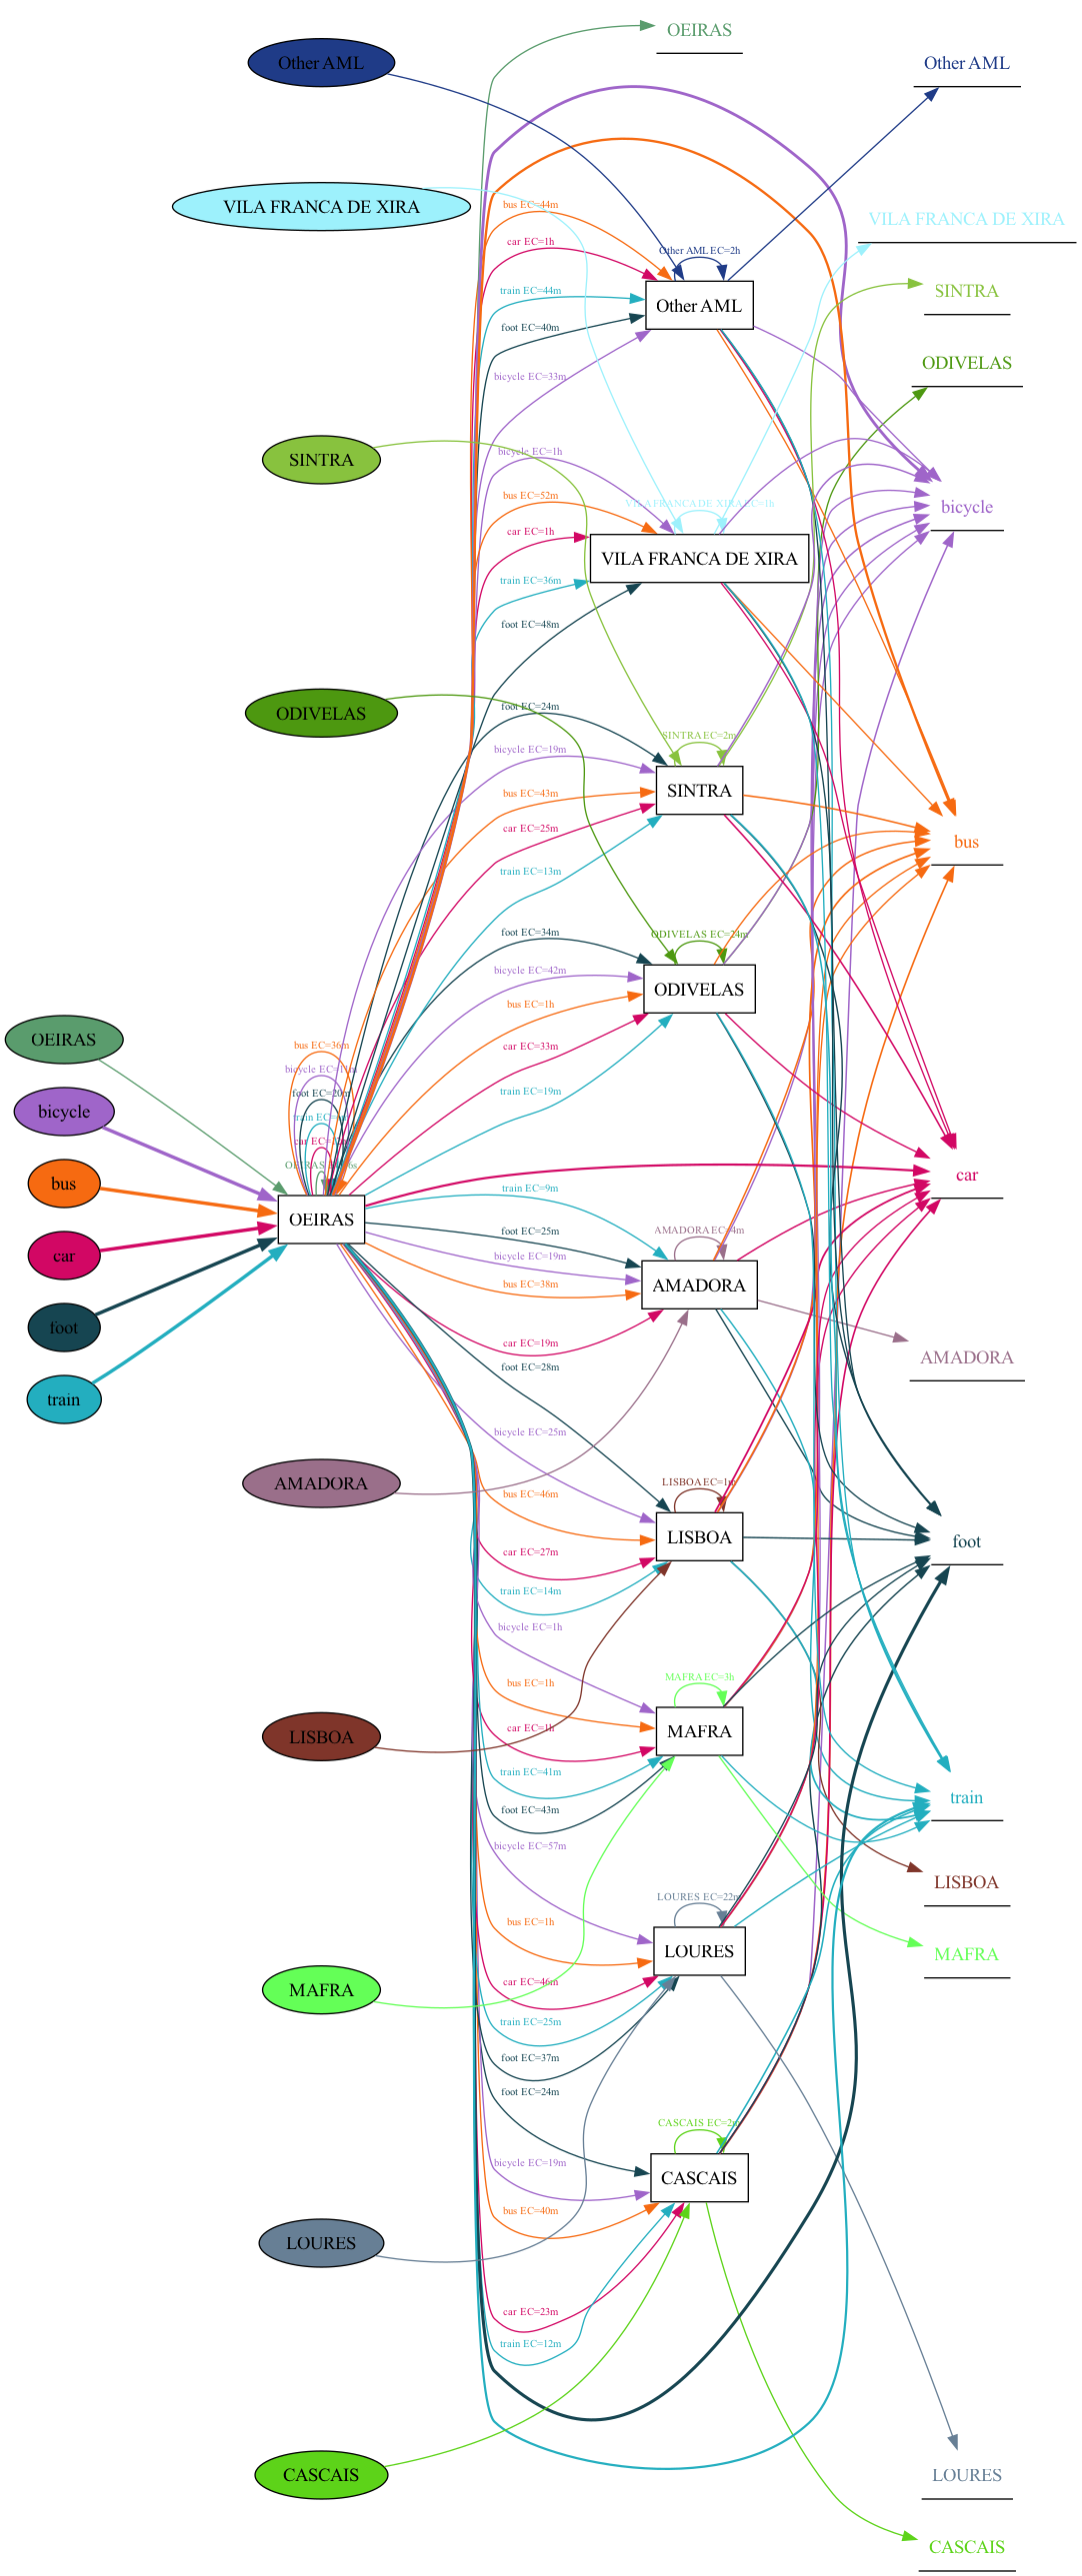

In [27]:
ocdfg = pm4py.discover_ocdfg(ocel_df_oeiras)
    # View the model with the performance annotation
pm4py.view_ocdfg(ocdfg, format="png", annotation="performance", performance_aggregation="median")

In [42]:
print(ocel_df_oeiras)

Object-Centric Event Log (number of events: 658026, number of objects: 329023, number of activities: 10, number of object types: 15, events-objects relationships: 1316052)
Activities occurrences: Counter({'OEIRAS': 554372, 'LISBOA': 35362, 'CASCAIS': 26410, 'SINTRA': 21849, 'AMADORA': 13418, 'LOURES': 2672, 'ODIVELAS': 2456, 'VILA FRANCA DE XIRA': 669, 'Other AML': 493, 'MAFRA': 325})
Object types occurrences (number of objects): Counter({'foot': 164514, 'bus': 49397, 'bicycle': 44746, 'car': 38294, 'train': 32062, 'AMADORA': 1, 'CASCAIS': 1, 'LISBOA': 1, 'LOURES': 1, 'MAFRA': 1, 'ODIVELAS': 1, 'OEIRAS': 1, 'Other AML': 1, 'SINTRA': 1, 'VILA FRANCA DE XIRA': 1})
Unique activities per object type: Counter({'bicycle': 10, 'bus': 10, 'car': 10, 'foot': 10, 'train': 10, 'AMADORA': 1, 'CASCAIS': 1, 'LISBOA': 1, 'LOURES': 1, 'MAFRA': 1, 'ODIVELAS': 1, 'OEIRAS': 1, 'Other AML': 1, 'SINTRA': 1, 'VILA FRANCA DE XIRA': 1})
Please use <THIS>.get_extended_table() to get a dataframe representation 

In [38]:
filtered_ocel = pm4py.filter_ocel_object_types(ocel_df_oeiras, ['OEIRAS', 'LISBOA','car', 'bus'])

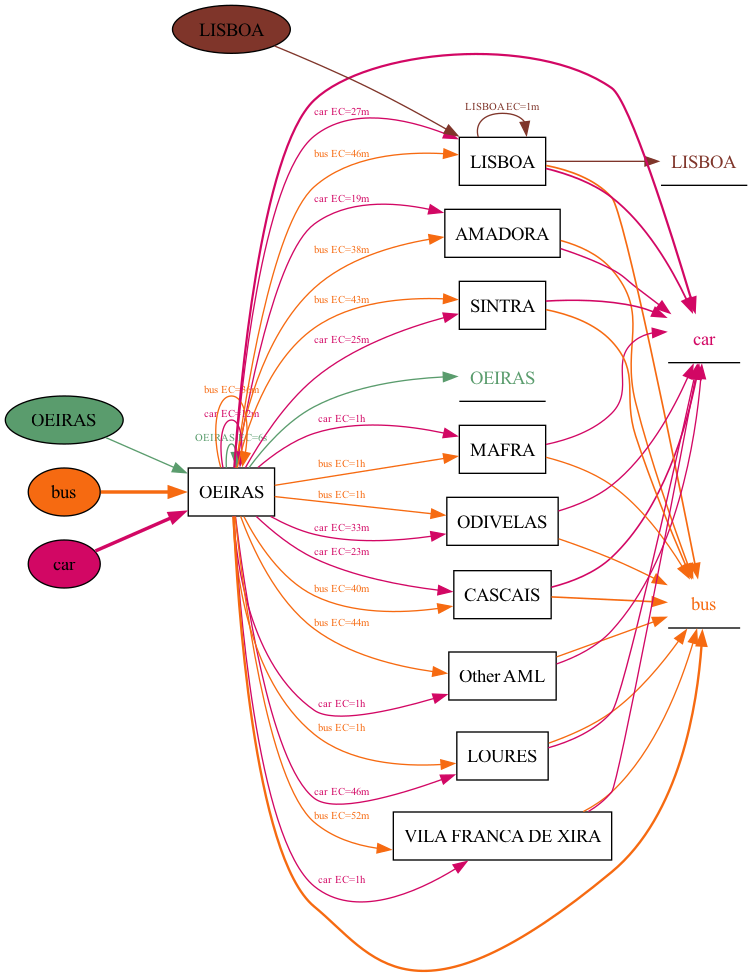

In [39]:
ocdfg = pm4py.discover_ocdfg(filtered_ocel)
    # View the model with the performance annotation
pm4py.view_ocdfg(ocdfg, format="png", annotation="performance", performance_aggregation="median")

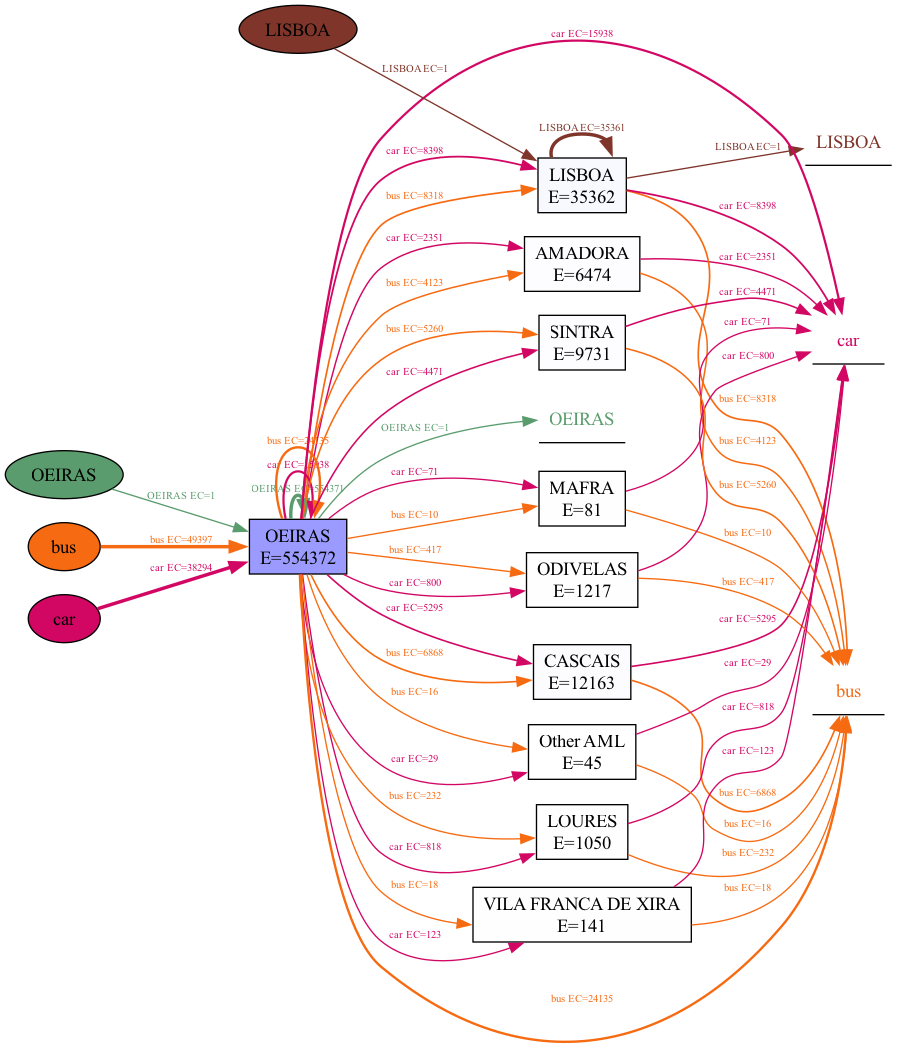

In [40]:
ocdfg = pm4py.discover_ocdfg(filtered_ocel)
    # View the model with the performance annotation
pm4py.view_ocdfg(ocdfg, format="png", annotation="frequency", performance_aggregation="median")